# NLP CW Task 1

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks
  - Your .README file should explain how to replicate the different experiments mentioned in your report

# Setup

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from collections import Counter
import nltk
import string
import torchtext
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import re
import spacy

In [2]:
# Get pretrained GloVe embeddings
glove = torchtext.vocab.GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [06:56, 2.07MB/s]                          
100%|█████████▉| 399141/400000 [00:11<00:00, 33749.06it/s]

In [3]:
# Install packages that Colab does not provide automatically
!pip -q install transformers
from transformers import RobertaTokenizer, RobertaModel, BertPreTrainedModel, DistilBertModel, DistilBertTokenizer

# Download stopwords
nltk.download('stopwords')

# Download spacy model
!spacy download en_core_web_sm -q
ner = spacy.load('en_core_web_sm')

# Get test and train data files
if not os.path.exists('dev.csv'):
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/dev.csv
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/train.csv
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/competition_test.csv

     |████████████████████████████████| 1.9MB 5.8MB/s 
     |████████████████████████████████| 3.2MB 30.2MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
dev.csv             100%[===================>] 211.85K  --.-KB/s    in 0.03s   
train.csv           100%[===================>] 925.70K  --.-KB/s    in 0.07s   
competition_test.cs 100%[===================>] 290.38K  --.-KB/s    in 0.04s   


In [4]:
# Set random seed and device
SEED = 1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('dev.csv')
comp_df = pd.read_csv('competition_test.csv')

In [9]:
# Build columns in dataset for edited headline and original word
def build_edit_cols(dataset):
  edited = []
  original_words = []
  for i in range(len(dataset)):
    original_words.append(re.search(r'<(.*)/>', dataset['original'][i]).group(1))
    edited.append(re.sub(r'<.*/>', dataset['edit'][i], dataset['original'][i]))
  dataset['edited'] = edited
  dataset['originalWord'] = original_words

build_edit_cols(train_df)
build_edit_cols(test_df)
build_edit_cols(comp_df)

# Approach 1
Using pre-trained representations

In [10]:
# Training loop
def train(train_iter, dev_iter, model, number_epoch, optimizer):
  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(DEVICE)

  performance_stats = []

  for epoch in range(1, number_epoch+1):
    model.train()

    epoch_loss = 0
    epoch_sse = 0
    no_observations = 0  # Observations used for training so far

    for batch in train_iter:
      ids = batch['ids'].to(DEVICE).squeeze()
      mask = batch['mask'].to(DEVICE).squeeze()
      target = batch['target'].to(DEVICE, dtype=torch.float)
      extra_features = batch['extra_features'].to(DEVICE)

      predictions = model(ids, mask, extra_features).squeeze(1)
      optimizer.zero_grad()
      loss = loss_fn(predictions, target)

      no_observations = no_observations + target.shape[0]
      sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse

    valid_loss, valid_mse, __, __ = eval(dev_iter, model)

    epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
    performance_stats.append((valid_loss, valid_mse**0.5))
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
    Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

  return performance_stats

In [11]:
# Evaluate performance
def eval(data_iter, model):
  model.eval()
  epoch_loss = 0
  epoch_sse = 0
  pred_all = []
  trg_all = []
  no_observations = 0
  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(DEVICE)

  with torch.no_grad():
    for batch in data_iter:
      ids = batch['ids'].to(DEVICE).squeeze()
      mask = batch['mask'].to(DEVICE).squeeze()
      target = batch['target'].to(DEVICE, dtype=torch.float)
      extra_features = batch['extra_features'].to(DEVICE)

      predictions = model(ids, mask, extra_features).squeeze(1)

      loss = loss_fn(predictions, target)

      # We get the mse
      pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
      sse, __ = model_performance(pred, trg)

      no_observations = no_observations + target.shape[0]
      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse
      pred_all.extend(pred)
      trg_all.extend(trg)

  return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [12]:
# Get SSE and MSE
def model_performance(output, target, print_output=False):
  sq_error = (output - target)**2
  sse = np.sum(sq_error)
  mse = np.mean(sq_error)
  rmse = np.sqrt(mse)

  if print_output:
    print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

  return sse, mse

# Data Analysis


Number of Headlines: 9652, Max Headline Length: 146, Avg Score: 0.94
Most common words: [('Trump', 3320), ('The', 557), ('House', 488), ('says', 483), ('Donald', 356)]
Headlines with Trump: 39.11%, Avg Score: 1.02
Proportion of Trump Headlines with score > 1: 42.38%


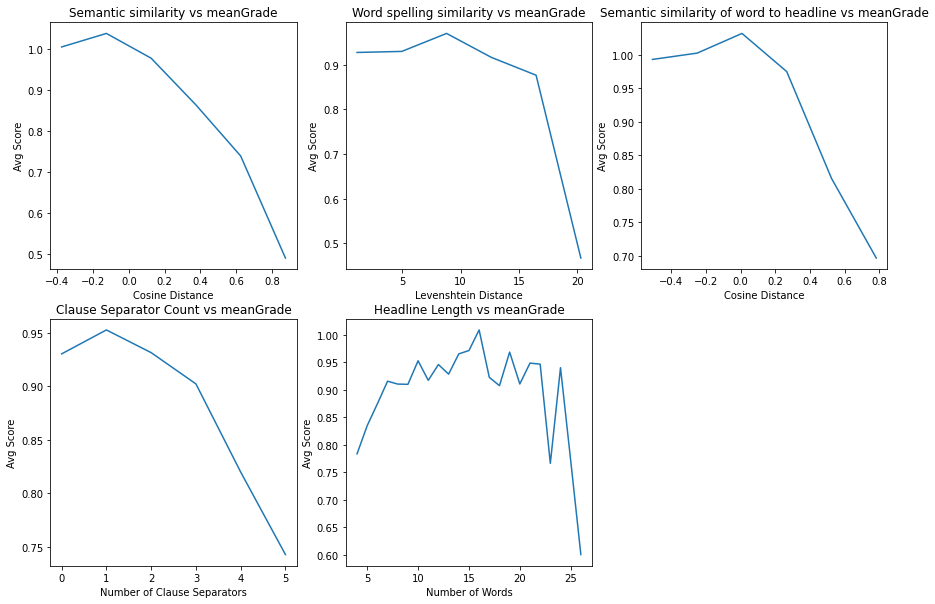

In [14]:
# Basic Stats
num_headlines = len(train_df)
max_len = max(train_df['original'].apply(len))
avg_score = train_df['meanGrade'].mean()
print(f'Number of Headlines: {num_headlines}, Max Headline Length: {max_len}, Avg Score: {avg_score:.2f}')

# Most common words
stopwords = nltk.corpus.stopwords.words('english')
most_common_words = Counter(" ".join(train_df['original']).split()).most_common(100)
stopwords.append(string.punctuation)
most_common_words = [(word, count) for (word, count) in most_common_words if word not in stopwords and word.isalpha()][:5]
print(f'Most common words: {most_common_words}')

# Analysis of Trump Headlines
trump_headlines = train_df[train_df['original'].str.lower().str.contains('trump')]
num_headlines_with_trump = len(trump_headlines)
trump_avg_score = trump_headlines['meanGrade'].mean()
prob_headline_contains_trump = num_headlines_with_trump / num_headlines
trump_value_counts = trump_headlines['meanGrade'].value_counts(bins=3)
trump_proportion_gt_one = (trump_value_counts[2] + trump_value_counts[3]) * 100 / num_headlines_with_trump
print(f'Headlines with Trump: {prob_headline_contains_trump * 100:.2f}%, Avg Score: {trump_avg_score:.2f}')
print(f'Proportion of Trump Headlines with score > 1: {trump_proportion_gt_one:.2f}%')

# Analysis of word similarity and length of headlines
semantic_similarity_data = []
sentence_similarity_data = []
levenshtein_similarity_data = []
headline_length_data = []

for row in train_df.itertuples():
  all_words = row.original.split(' ')
  headline_length_data.append((len(all_words), row.meanGrade))
  sentence_vec = torch.zeros((1,50))
  original_word_vec = glove[row.originalWord.lower()].unsqueeze(0)
  edited_word_vec = glove[row.edit.lower()].unsqueeze(0)

  for i, word in enumerate(all_words):
    if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
      word = word[1:-2].lower()
    sentence_vec += glove[word.lower()].unsqueeze(0)

  semantic_distance = torch.cosine_similarity(original_word_vec, edited_word_vec).item()
  levenshtein_distance = nltk.edit_distance(row.originalWord.lower(), row.edit.lower())
  semantic_similarity_data.append((semantic_distance, row.meanGrade))
  levenshtein_similarity_data.append((levenshtein_distance, row.meanGrade))
  sentence_semantic_distance = torch.cosine_similarity(sentence_vec, edited_word_vec)
  sentence_similarity_data.append((sentence_semantic_distance, row.meanGrade))


# Analysis of # of clause separators
separators_data = []
for i in range(len(train_df['original'])):
  matches = re.findall("[;,:(...)]", train_df['original'][i])
  separators_data.append((len(matches), train_df['meanGrade'][i]))

# Plot word similarity vs meanGrade
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
mean_stat_similarity = binned_statistic(*zip(*semantic_similarity_data), bins=6, range=(-0.5, 1.0))
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Cosine Distance')
plt.ylabel('Avg Score')
plt.title('Semantic similarity vs meanGrade')

# Levenshtein distance vs meanGrade
plt.subplot(2, 3, 2)
mean_stat_similarity = binned_statistic(*zip(*levenshtein_similarity_data), bins=6)
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Avg Score')
plt.title('Word spelling similarity vs meanGrade')

# Semantic similarity of word to headline vs meanGrade
plt.subplot(2, 3, 3)
mean_stat_similarity = binned_statistic(*zip(*sentence_similarity_data), bins=6)
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Cosine Distance')
plt.ylabel('Avg Score')
plt.title('Semantic similarity of word to headline vs meanGrade')

# Plot clause separator count vs meanGrade
plt.subplot(2, 3, 4)
plt.plot()
mean_stat_seps = binned_statistic(*zip(*separators_data), bins=6)
plt.plot(mean_stat_seps.bin_edges[:-1], mean_stat_seps.statistic)
plt.xlabel('Number of Clause Separators')
plt.ylabel('Avg Score')
plt.title('Clause Separator Count vs meanGrade')

# Plot headline length vs meanGrade
plt.subplot(2, 3, 5)
mean_stat_headline_len = binned_statistic(*zip(*headline_length_data), bins=30, range=(0, 30))
plt.plot(mean_stat_headline_len.bin_edges[:-1], mean_stat_headline_len.statistic)
plt.xlabel('Number of Words')
plt.ylabel('Avg Score')
plt.title('Headline Length vs meanGrade')

plt.show()

## Preprocessing

In [31]:
# Pattern to match words and multiword tags
# See https://regex101.com/r/a2cWZL/1 for example
# TOKEN_PATTERN = re.compile("[A-Za-z#]+|<[A-Za-z#]+\s[A-Za-z]+\/>")

# Patten to match only words
TOKEN_PATTERN = re.compile("\w+")
CLAUSE_SEPS = re.compile("[;,:(...)]")

# TODO: processing of:
# - hashtags,
# - words with a "-" in between them
# - punctuation
# - entity names

def tokenize(sentence):
  return TOKEN_PATTERN.findall(sentence)

# Remove angle brackets and lowercase
def preprocess(word):
  if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
    word = word[1:-2]
  return word.lower()

def create_vocab(data):
  """
  Creating a corpus of all the tokens used
  """
  # Let us put the tokenized corpus in a list
  tokenized_corpus = [[preprocess(t) for t in tokenize(s)] for s in data]

  # Create single list of all vocabulary
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)

  return vocabulary, tokenized_corpus

# Extra features:
# [0] - binary if 'Trump' in headline
# [1] - length of headline
# [2] - number of clause separators: elipsis, commas, colons or semi colons
# [3] - semantic distance between original and edit word glove embedding
# [4] - semantic distance between edit word and total original headline glove embedding
# [5] - edit distance between edit word and original word
EXTRA_FEATURES = 6
def extract_features(raw_headline, original_word, edit_word):
  sentence_vec = torch.zeros((1, 50))
  original_word_vec = glove[original_word.lower()].unsqueeze(0)
  edited_word_vec = glove[edit_word.lower()].unsqueeze(0)

  for i, word in enumerate(raw_headline.split(' ')):
    if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
      word = word[1:-2].lower()
    sentence_vec += glove[word.lower()].unsqueeze(0)

  semantic_distance = torch.cosine_similarity(original_word_vec, edited_word_vec).item()
  levenshtein_distance = nltk.edit_distance(original_word.lower(), edit_word.lower())
  sentence_semantic_distance = torch.cosine_similarity(sentence_vec, edited_word_vec)

  return [
    int('Trump' in raw_headline),
    len(raw_headline),
    len(CLAUSE_SEPS.findall(raw_headline)),
    semantic_distance,
    sentence_semantic_distance,
    levenshtein_distance
  ]

In [32]:
# Inherits from Dataset class so the DataLoader can use it
class Task1Dataset(Dataset):

  def __init__(self, tokenizer, train_data, labels):
    self.x_train = train_data
    self.y_train = labels
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    # Preprocess headline before embedding
    headline = self.x_train[0][item]
    original_word = self.x_train[1][item]
    edit_word = self.x_train[2][item]
    # processed_headline = ' '.join([preprocess(t) for t in tokenize(headline)])
    processed_headline = [preprocess(t) for t in tokenize(headline)]

    target = self.y_train[item]

    # Use is_split_into_words=True to allow for our own tokenizing
    # - stops encode_plus splitting up unknown words into multiple parts
    encoding = self.tokenizer.encode_plus(processed_headline, return_tensors='pt',
                                          padding='max_length', truncation=True,
                                          max_length=128, pad_to_max_length=True,
                                          is_split_into_words=True)
    ids = encoding['input_ids']
    mask = encoding['attention_mask']

    extra_features = extract_features(headline, original_word, edit_word)

    return {
      'ids': torch.tensor(ids),
      'mask': torch.tensor(mask),
      'target': torch.tensor(target),
      'extra_features': torch.tensor(extra_features)
    }

In [33]:
class BertRegressionModel(nn.Module):
  def __init__(self, model_name):
    super(BertRegressionModel, self).__init__()

    if model_name == 'distilbert':
      self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    elif model_name == 'roberta':
      self.bert = RobertaModel.from_pretrained('roberta-base')

    self.num_extra_features = EXTRA_FEATURES
    self.linear1 = nn.Linear(768, 32)
    self.linear2 = nn.Linear(32 + self.num_extra_features, 1)

  def forward(self, ids, mask, extra_features):
    embeddings = self.bert(input_ids=ids, attention_mask=mask)[0]
    x = self.linear1(embeddings[:, 0])
    concat_features = torch.cat([x, extra_features], dim=1)
    x = self.linear2(concat_features)
    return x

### Approach 1: Using pre-trained representations

In [34]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

BATCH_SIZE = 32

# Initialise chosen BERT model and tokenizer
# To change the model to use Roberta, pass in 'roberta' to the regression model
# and uncomment the tokenizer below.
model = BertRegressionModel('distilbert').to(DEVICE)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

training_data = [train_df['edited'], train_df['originalWord'], train_df['edit']]
training_labels = train_df['meanGrade']
test_data = test_df['edited']
train_and_dev = Task1Dataset(tokenizer, training_data, training_labels)

# Split training data into train and dev sets
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev, (train_examples, dev_examples))

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

In [35]:
# Do the training
distil_model = BertRegressionModel('distilbert').to(DEVICE)
optimizer_distil = torch.optim.Adam(distil_model.parameters())
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

roberta_model = BertRegressionModel('roberta').to(DEVICE)
optimizer_roberta = torch.optim.Adam(roberta_model.parameters())
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

print('Training roberta model...')
performance_stats_roberta = train(train_loader, dev_loader, roberta_model, epochs, optimizer_roberta)
print('Training distil-bert model...')
performance_stats_distil = train(train_loader, dev_loader, distil_model, epochs, optimizer_distil)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


| Epoch: 01 | Train Loss: 0.87 | Train MSE: 0.87 | Train RMSE: 0.93 |     Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |     Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |     Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
| Epoch: 04 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |     Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
| Epoch: 05 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.58 |     Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.58 |
| Epoch: 06 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.58 |     Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
| Epoch: 07 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.58 |     Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.56 |
| Epoch: 08 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |     Val. Loss: 0.32 | Val. MSE: 0.

In [36]:
# Save models
torch.save(roberta_model, 'roberta-model.pt')
torch.save(distil_model, 'distilbert-model.pt')

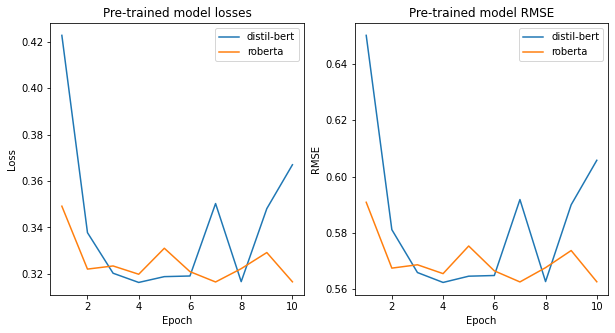

In [37]:
# Plot losses for both pre trained models
epoch_losses_1, rmse_1 = zip(*performance_stats_distil)
epoch_losses_2, rmse_2 = zip(*performance_stats_roberta)
x = np.arange(epochs) + 1

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, epoch_losses_1, label='distil-bert')
plt.plot(x, epoch_losses_2, label='roberta')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-trained model losses')

plt.subplot(1, 2, 2)
plt.plot(x, rmse_1, label='distil-bert')
plt.plot(x, rmse_2, label='roberta')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Pre-trained model RMSE')
plt.show()

**Approach 1: Evaluation**

In [47]:
model = roberta_model
# Evaluate model on the competition data
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set training and test data
comp_ids = comp_df['id']
comp_data = [comp_df['edited'], comp_df['originalWord'], comp_df['edit']]
comp_labels = comp_df['meanGrade']

comp_data = Task1Dataset(tokenizer, comp_data, comp_labels)
comp_loader = torch.utils.data.DataLoader(comp_data, batch_size=32)

_,_,predictions,_ = eval(comp_loader, model)

comp_preds = {'id': comp_ids, 'pred': predictions}
comp_preds = pd.DataFrame(comp_preds)
comp_preds.to_csv('pred_outputs.csv', index=False)
print('Saved pred_outputs.csv\n')

min_score = min(predictions)
max_score = max(predictions)
mean_score = sum(predictions) / len(predictions)
range = max_score - min_score
print(f'Min predicted score: {min_score}, Max predicted score: {max_score}, Range: {range}, Mean Predicted Score: {mean_score}\n')  
print(f'MSE and RMSE on the Competition Test Set:')
output = model_performance(predictions, comp_labels, print_output=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Saved pred_outputs.csv

Min predicted score: 0.60969078540802, Max predicted score: 1.35207998752594, Range: 0.7423892021179199, Mean Predicted Score: 0.9491504904217821

MSE and RMSE on the Competition Test Set:
| MSE: 0.32 | RMSE: 0.56 |


## Approach 2
No pre-trained representations

In [ ]:
import collections
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([doc])
count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
count_occur_df.head()

In [ ]:
# TODO:
# - remove stop words
# - different norms
# - pre: weigh query terms higher for certain



####### TODO: is this up to date?? why is it only training on the edit words??
#######  need to use train_df['edited'] to train on the edited headline



train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)





# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.01 | RMSE: 0.09 |

Dev performance:
| MSE: 17.09 | RMSE: 4.13 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |


### Approach 2: Neural Network

In [ ]:
class Task1DatasetNN(Dataset):

  def __init__(self, train_data, labels, max_len, word2idx, entity2idx, stopwords=nltk.corpus.stopwords.words('english')):
    self.x_train = train_data
    self.y_train = labels
    self.stopwords = stopwords
    self.max_len = max_len
    self.word2idx = word2idx
    self.entity2idx = entity2idx

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    headline = self.x_train[item]

    # Remove punctuation
    headline = re.sub(r'[^\w\s]', '', headline)

    # Map headlines to list of entity IDs
    # entities = [self.entity2idx[str(e)] for e in ner(headline).ents if str(e) in self.entity2idx]

    # Tokenize, lowercase, remove stop words
    headline = [w.lower() for w in headline.split() if w not in self.stopwords and len(w)]

    # Get headline vector
    vectorized_headline = [self.word2idx[tok] for tok in headline if tok in self.word2idx]
    headline_tensor = torch.zeros((self.max_len,)).long()
    headline_tensor[:len(vectorized_headline)] = torch.LongTensor(vectorized_headline)

    target_tensor = torch.FloatTensor([self.y_train[item]])
    extra_features = []

    return {
      'encoding': headline_tensor,
      'extra_features': torch.tensor(extra_features),
      'target': target_tensor
    }

In [ ]:
TOKEN_PATTERN = re.compile("\w+")
def tokenize(sentence):
  return TOKEN_PATTERN.findall(sentence)

# Remove angle brackets and lowercase
def preprocess(word):
  if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
    word = word[1:-2]
  return word.lower()

# Create vocab of all words
def create_vocab(data):
  # Let us put the tokenized corpus in a list
  tokenized_corpus = [[preprocess(t) for t in tokenize(s)] for s in data]

  # Create single list of all vocabulary
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)

  return vocabulary, tokenized_corpus

# TODO: need to tie this in with NER
def build_word2idx(tokenized_corpus):
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)
  w2i = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
  w2i['<pad>'] = 0
  return w2i

# Get NER lookup table from training data
def build_entity2idx(corpus):
  entities = {}
  idx = 0
  for s in corpus:
    doc = ner(s)
    for e in doc.ents:
      e = str(e)
      if e not in entities:
        entities[e] = idx
        idx+=1
  return entities

In [ ]:
class FFNN(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
    super(FFNN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.fc1 = nn.Linear(embedding_dim, hidden_dim)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, num_classes)
    self.relu2 = nn.ReLU()

  # Average sentence embedding (ignoring padding)
  # Maps embedded : (batch_size, max_sent_len, embedding_dim) => (batch_size, embeddind_dim)
  def average_embedding(self, embedded):
    # Want to calculate the avg embedding across all words
    # This is the max_sent_len dimension so dim=1
    total_emb = torch.sum(embedded, dim=1)

    # Count number of non-zero embeddings to average over
    non_zero_embs = torch.sum(embedded != 0, dim=[1])
    avg_emb = total_emb / non_zero_embs

    return avg_emb

  def forward(self, x):
    # x has shape (batch_size, max_sent_len)
    embedded = self.embedding(x)

    # embedding has shape (batch_size, max_sent_len, embedding_dim)
    # Compute the average embeddings of shape (batch_size, embedding_dim)
    averaged = self.average_embedding(embedded)

    # TODO: extra features

    out = self.fc1(averaged)
    out = self.relu1(out)
    out = self.fc2(out)
    # out = self.relu2(out)
    return out

In [ ]:
EPOCHS = 10
LRATE = 0.1
EMBEDDING_DIM = 20 # ~4th root of vocab size
HIDDEN_DIM = 50
OUTPUT_DIM = 1

# Set training and test data
training_data = train_df['edited']
training_labels = train_df['meanGrade']
test_data = test_df['edited']

_vocab, tokenized_corpus = create_vocab(training_data)
max_headline_len = max([len([w for w in s.split()]) for s in training_data])
w2i = build_word2idx(tokenized_corpus)
# e2i = build_entity2idx(training_data)
e2i = {}

train_and_dev = Task1DatasetNN(training_data, training_labels, max_headline_len, w2i, e2i)

# TODO: what processing should be done on both train and dev and what should be done on just train???
# Split training data into train and dev sets
train_examples = round(len(training_data)*train_proportion)
dev_examples = len(training_data) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev, (train_examples, dev_examples))

In [ ]:
# Create data loaders
BATCH_SIZE = 50
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(w2i), OUTPUT_DIM)
print(model)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=LRATE)

# we use the binary cross-entropy loss with sigmoid (applied to logits)
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.MSELoss()

# Start training
EPOCHS = 10
for epoch in range(EPOCHS):
  # to ensure the dropout (explained later) is "turned on" while training
  # good practice to include even if do not use here
  model.train()

  for batch in train_loader:

    encoding = batch['encoding'].to(DEVICE)
    target = batch['target'].to(DEVICE).squeeze(1)
    # extra_features = batch['extra_features'].to(DEVICE)

    # we zero the gradients as they are not removed automatically
    optimizer.zero_grad()

    # squeeze is needed as the predictions will have the shape (batch size, 1)
    # and we need to remove the dimension of size 1
    predictions = model(encoding).squeeze(1)

    # Compute the loss
    loss = loss_fn(predictions, target)
    train_loss = loss.item()

    # calculate the gradient of each parameter
    loss.backward()

    # update the parameters using the gradients and optimizer algorithm
    optimizer.step()

  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f}')

FFNN(
  (embedding): Embedding(10433, 20, padding_idx=0)
  (fc1): Linear(in_features=20, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (relu2): ReLU()
)
| Epoch: 00 | Train Loss: 0.248
| Epoch: 01 | Train Loss: 0.508
| Epoch: 02 | Train Loss: 0.239
| Epoch: 03 | Train Loss: 0.315
| Epoch: 04 | Train Loss: 0.212
| Epoch: 05 | Train Loss: 0.268
| Epoch: 06 | Train Loss: 0.190
| Epoch: 07 | Train Loss: 0.291
| Epoch: 08 | Train Loss: 0.334
| Epoch: 09 | Train Loss: 0.361
